In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For aesthetical reasons
import scipy.signal as sg  # Package for signal analysis
import h5py  # Package for reading HDF5-files
import datetime as dt  # To get aesthetical date formats
import matplotlib.transforms as transforms  # For use in construction of the variance matrix

from scipy import stats  # Used for 2D binned statistics
from matplotlib.patches import Ellipse  # Our patch for plotting the variance matrix
from pandas.plotting import register_matplotlib_converters  # So that matplotlib understands datetime formats
register_matplotlib_converters()


sns.set()
sns.set_style("whitegrid")  # Choosing which style to use for our plots

First we have to read in the data from a .mat file. Unfortunately the function for doing this is deprecated ever since .mat files became HDF5 files. Luck for us there is a way around it, although a bit clunky. We begin by opening the file and looking at the keys of the file. In this syntax I have to keep opening the file in every cell, but with your code in a text editor you would only have to do it once.

In [2]:
datadir = "../data/"
with h5py.File(datadir + "m1244.mat",'r') as file:
    print(file.keys())

<KeysViewHDF5 ['#refs#', 'm1244']>


We see that the file has two keys: "#refs#" and "m1244". An educated guess makes me choose to look at "m1244".

In [3]:
with h5py.File(datadir + "m1244.mat",'r') as file:
    variables = list(file.get("m1244"))
    print(variables)

['creator', 'cv', 'depths', 'description', 'lat', 'link', 'lon', 'num', 'p', 't', 'timestamp']


Now we get a list of the variables contained in the file. We then have to access each variable in order and store them. To do this I use a dictionary and a loop.

In [4]:
with h5py.File(datadir + "m1244.mat",'r') as file:
    data = {}
    for i in variables:
        data[i] = np.array(file.get(f"m1244/{i}")).squeeze()  # squeeze() removes excessive dims

At this point we would be done reading the file. However, python ends up formatting the complex numbers as a tuple (real, imag). We would like to keep the complex number structure, and so we iterate over each tuple and store them as complex numbers before overwriting them in the dictionary.

In [5]:
with h5py.File(datadir + "m1244.mat",'r') as file:
    cv = np.zeros((data["cv"].shape[0], data["cv"].shape[1]), dtype=complex)
    for i in range(len(data["cv"])):
        for j in range(len(data["cv"][0])):
            cv[i][j] = data["cv"][i][j][0] + 1j*data["cv"][i][j][1]  # 1j is the imaginary number
    data["cv"] = cv

The "num" data is our time axis formatted in the MATLAB format datenum. We would like to display it as datetime objects. The function we use only supports integers, but some number theory arithmetics lets us keep all the information.

In [6]:
with h5py.File(datadir + "m1244.mat",'r') as file:
    num = []
    for i in data["num"]:
        num.append(dt.datetime.fromordinal(int(i)) + dt.timedelta(days=i%1) - dt.timedelta(days = 366))
    data["num"] = np.array(num)

Now we're done with reading the data, and we can begin by taking a look at the deepest mooring.

<IPython.core.display.Javascript object>


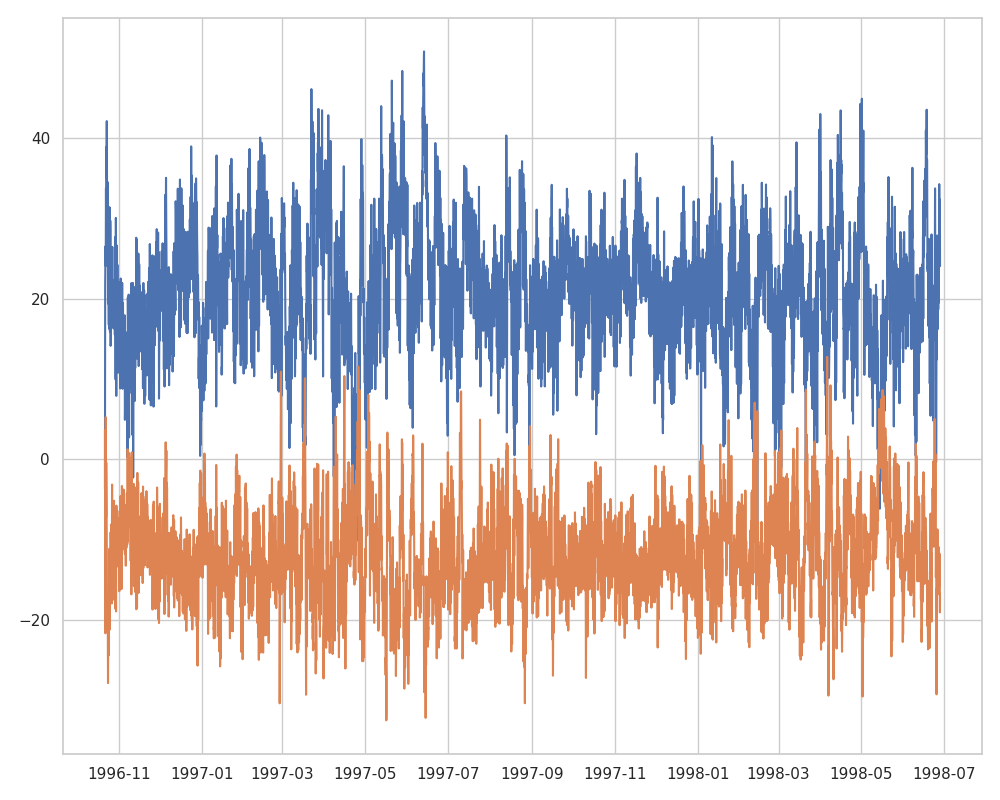

In [7]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(data["num"], data["cv"][3].real)
ax.plot(data["num"], data["cv"][3].imag)
fig.tight_layout()

We now rotate the velocity by the mean flow direction. As we are using complex numbers this is straightforward. Furthermore, we want to smooth the graph a bit. To do this we use the scipy.signal package.

In [10]:
phi = np.angle(np.mean(data["cv"][3]))
cv_rotated = data["cv"]*np.exp(-1j*phi)

window = sg.windows.hann(24)
cv_smoothed = sg.convolve(cv_rotated[3], window, mode="same") / np.sum(window) # we have to normalise

Now we can take a look at the rotated currents

<IPython.core.display.Javascript object>


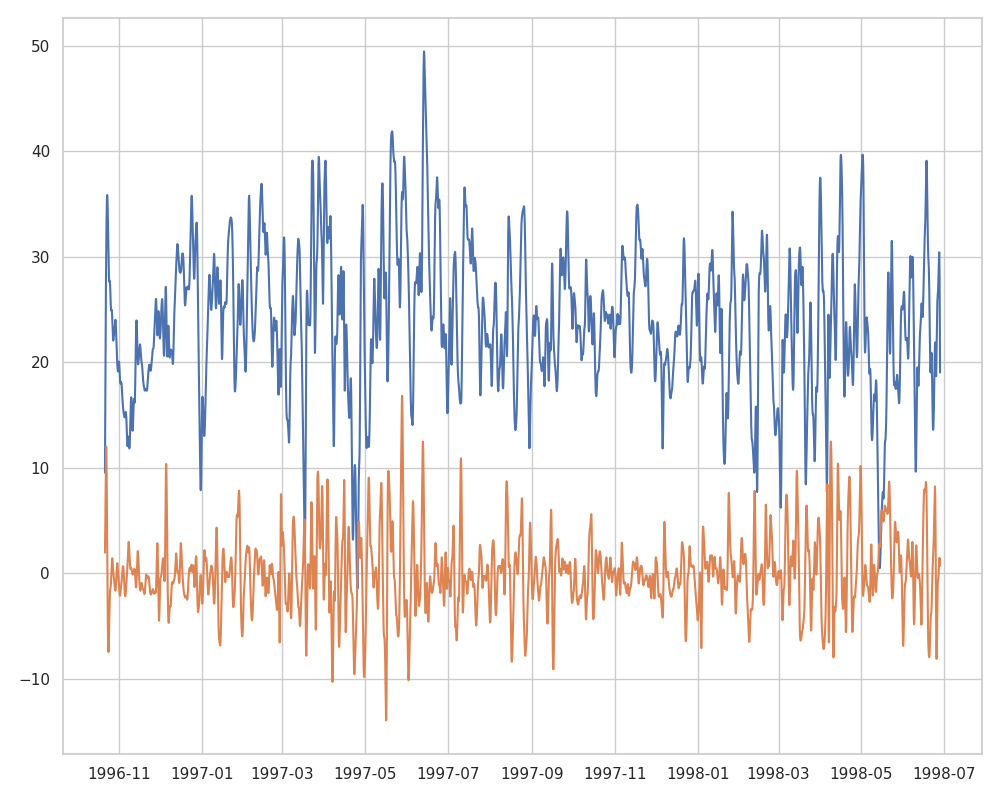

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(data["num"], cv_smoothed.real)
ax.plot(data["num"], cv_smoothed.imag)
fig.tight_layout()

We now want to look at the 2D histogram.

<IPython.core.display.Javascript object>


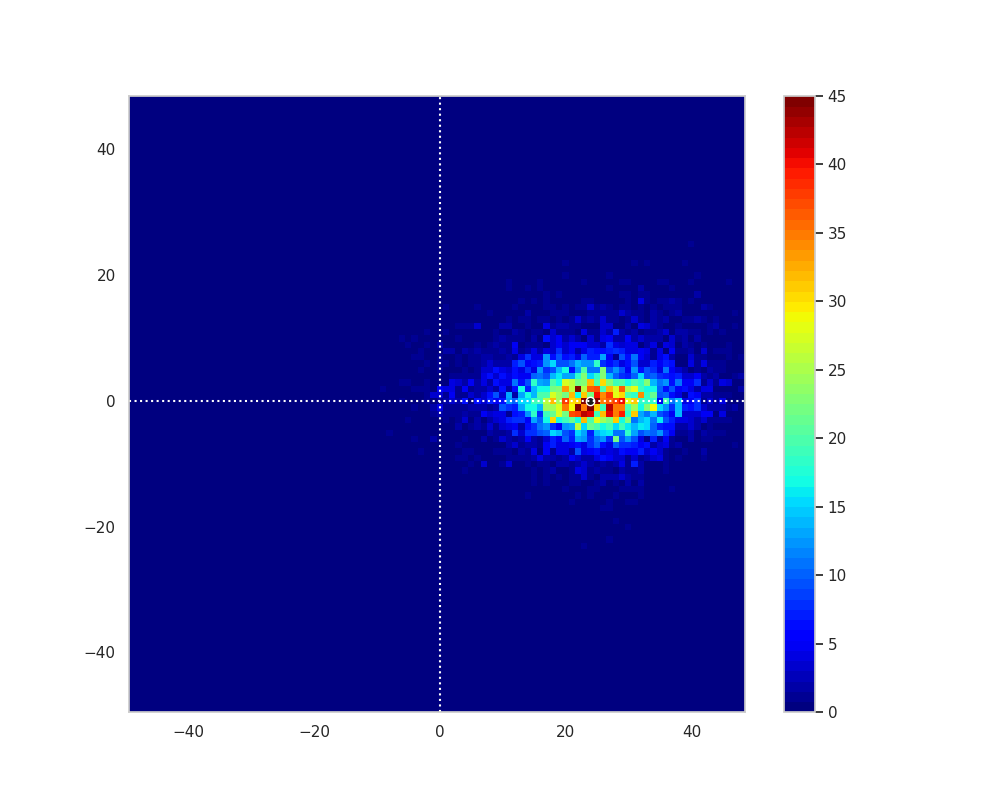

In [12]:
# Defining bins which in this case are equal
ubins = np.arange(-50, 50, 1)
vbins = np.arange(-50, 50, 1)

# Calculating histogram and bin centers
H = stats.binned_statistic_2d(cv_rotated[3].real, cv_rotated[3].imag, None, bins=[ubins, vbins], statistic="count")
ucenter = 0.5*(H.x_edge[1:] + H.x_edge[:-1])
vcenter = 0.5*(H.y_edge[1:] + H.y_edge[:-1])

U, V = np.meshgrid(ucenter, vcenter, indexing="ij")


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cmap = plt.cm.get_cmap("jet", 60)
im = ax.pcolormesh(U, V, H.statistic,
                    vmin=0,
                    vmax=45,
                    cmap=cmap,
                    shading="flat",
                    )
fig.colorbar(im, ax=ax)
ax.plot(np.mean(cv_rotated[3]).real, np.mean(cv_rotated[3]).imag, "wo", markerfacecolor="k")
ax.axhline(0, linestyle=":", color="white")
ax.axvline(0, linestyle=":", color="white")
ax.set_aspect("equal")

To plot the variance ellipse we use a function from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html which employs a different way of calculating the ellipse.
Theory: https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

In [13]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

<IPython.core.display.Javascript object>


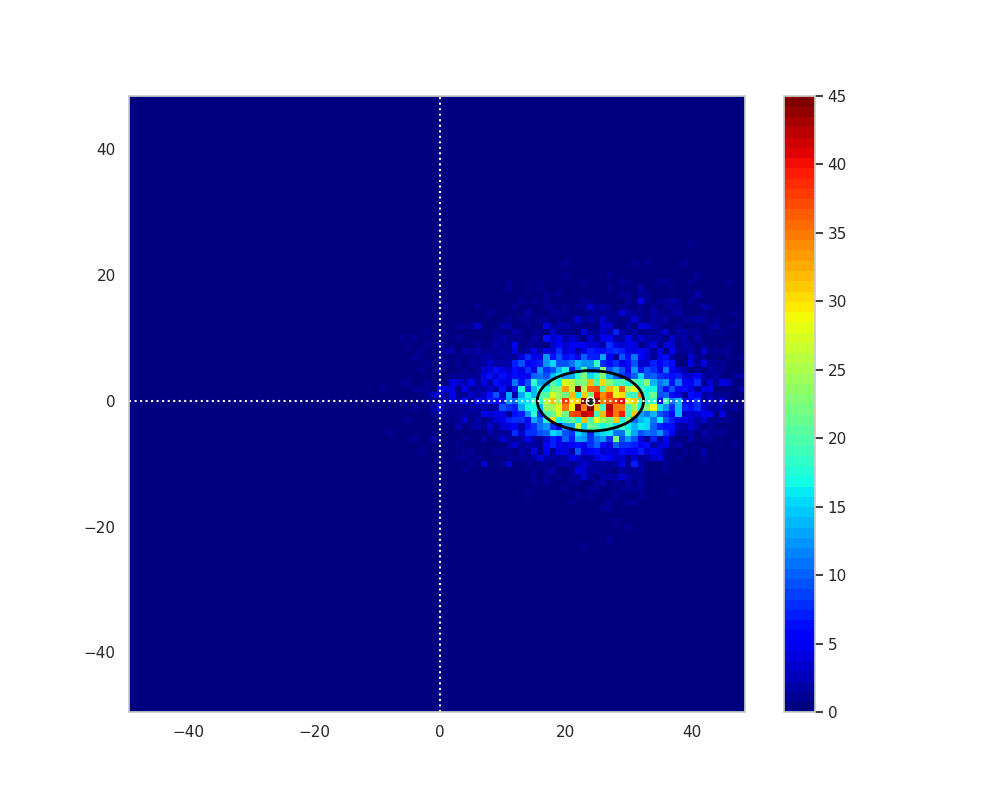

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cmap = plt.cm.get_cmap("jet", 60)
im = ax.pcolormesh(U, V, H.statistic,
                    vmin=0,
                    vmax=45,
                    cmap=cmap,
                    shading="flat",
                    )
fig.colorbar(im, ax=ax)
ax.plot(np.mean(cv_rotated[3]).real, np.mean(cv_rotated[3]).imag, "wo", markerfacecolor="k")
ax.axhline(0, linestyle=":", color="white")
ax.axvline(0, linestyle=":", color="white")
ax.set_aspect("equal")

confidence_ellipse(cv_rotated[3].real, cv_rotated[3].imag, ax=ax, n_std=1, edgecolor="black", linewidth=2)